# Food: a relevant marker of social inequalities?

In [1]:
# Imports
from urllib.request import urlopen
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import ttest_ind
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import warnings
# Uncomment to hide Warnings
#warnings.filterwarnings('ignore')

import platform

import os
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

In [8]:
# Constants
FIG_SIZE=(10,6)

## Study of OpenFoodFact

### Data cleaning

In [2]:
# Data
OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
OFF_API_QUERY_PATH = "https://world.openfoodfacts.org/cgi/search.pl?{}&page_size=1000&action=process&json=1"

def getOFFDataFrame(adress, path = OFF_API_PATH):
    """
    Queries OFF database with local adress contained in adress. Formatting url is contained in path.
    """
    result = json.load(urlopen(path.format(adress)))
#     print("{} entries gathered".format(result["count"]))
    if "products" in result:
        return pd.DataFrame(result["products"])
    return pd.DataFrame(result["tags"])

def getOFFDataFrameDict(qdict, n = 1000):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    return getOFFDataFrame(q, OFF_API_QUERY_PATH)

def getOFFDataFrameDictAux(qdict, n = 1000, log=False):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    i = 1
    dfs = []
    nbCurr = -1
    nbSamples = 0
    while (nbCurr != 0) & (nbSamples < n):
        dfs.append(getOFFDataFrame(q + "&page=" + str(i), OFF_API_QUERY_PATH))
        nbCurr = dfs[-1].shape[0]
        nbSamples += nbCurr
        i += 1
        if log: 
            print("{} samples gathered.".format(nbSamples))
    return pd.concat(dfs).head(n)

def getOFFDataFrameCat(tags=[], nutriments=[], n = 1000, log=False, **kwargs):
    """
    Queries the OFF data base with query informations contained in tags and nutriments. 
    <ul>
        <li>Tags should be a list of lists of shape: 
        [tag, value, &lt;conatins&gt;] where tag is the category of tag (ex. "brands") and value, the value to 
        be searched (ex. "Carrefour")</li>
        <li>Nutriments should be a list of lists of shape: [nutriment, comparison, value] where nutriment is the name of the nutriment to be 
        searched (ex. "magnesium"), comparison the nature of the comparison (ex. "lte") and 
        value the value to be compared with (ex. 50)</li>
    </ul>
    """
    qdict = {}
    qdict.update(parseTags(tags))
    qdict.update(parseNutriments(nutriments))
    qdict.update(kwargs)
    
    return getOFFDataFrameDictAux(qdict, n, log)

def parseTags(tags):
    """
    Converts tags into an appropriate dictionary like shape
    """
    qdict = {}
    for i, tagsEl in enumerate(tags):
        if len(tagsEl) == 2:
            contains = True
        else:
            contains = tagsEl[2]
        qdict["tagtype_{}".format(i)] = tagsEl[0]
        qdict["tag_contains_{}".format(i)] = ["does_not_contain","contains"][int(contains)]
        qdict["tag_{}".format(i)] = tagsEl[1]
    return qdict

def parseNutriments(nutriments):
    """
    Converts nutriments into an appropriate dictionary like shape
    """
    qdict = {}
    for i, nutrimentsEl in enumerate(nutriments):
        qdict["nutriment_{}".format(i)] = nutrimentsEl[0]
        qdict["nutriment_compare_{}".format(i)] = nutrimentsEl[1]
        qdict["nutriment_value_{}".format(i)] = nutrimentsEl[2]
        nutriment_i += 1
    return qdict

### Data formatting

### Data visualization

In [18]:
def getCategories(df, minlength=4, maxlength=20):
    cats = pd.DataFrame([x.lower() for cats in df["categories"] for x in re.split("\W", str(cats))], columns=["categories"])
    return cats[cats["categories"].apply(lambda x: (len(x) >= minlength) & (len(x) <= maxlength))]

def generateWordCloud(df, stopwordsAdd={},figsize=FIG_SIZE, **kwargs):
    stopwords = set(STOPWORDS)
    stopwords.update(stopwordsAdd)
    kwargsWC = {"background_color":"white", "stopwords":stopwords, "collocations":False, "width":720, "height":480, "margin":0, "colormap":"inferno"}
    kwargsWC.update(kwargs)
    categories = getCategories(df)
    categoriesText = " ".join(categories["categories"])
    
    wc = WordCloud(**kwargsWC).generate(categoriesText)

    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

def generate_mask(path):
    im = np.array(Image.open(path))
    im = im.mean(axis=2, dtype="int16")
    im = 255 * (im > 240)
    return im

def contains(strList, container):
    for s in strList:
        if s in container:
            return True
    return False

def toFloat(x):
    try:
        return float(x)
    except:
        return np.nan

def gatherCategory(df, categories):
    return df[df["categories"].apply(lambda x: contains(categories, str(x)))]

def gatherNutriments(df, nutriment, p=5):
    vals = df["nutriments"].apply(lambda x: toFloat(x.setdefault("{}_100g".format(nutriment), np.nan))).dropna().values
    if len(vals) == 0:
        return np.array([])
    vMin = np.percentile(vals, p)
    vMax = np.percentile(vals, 100 - p)
    return vals[(vals >= vMin) & (vals <= vMax)]

### Data analysis

In [12]:
organicDf = getOFFDataFrameCat(tags = [["labels", "organic"]], n= 20000)
nonOrganicDf = getOFFDataFrameCat(tags = [["labels", "organic", False]], n=30000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



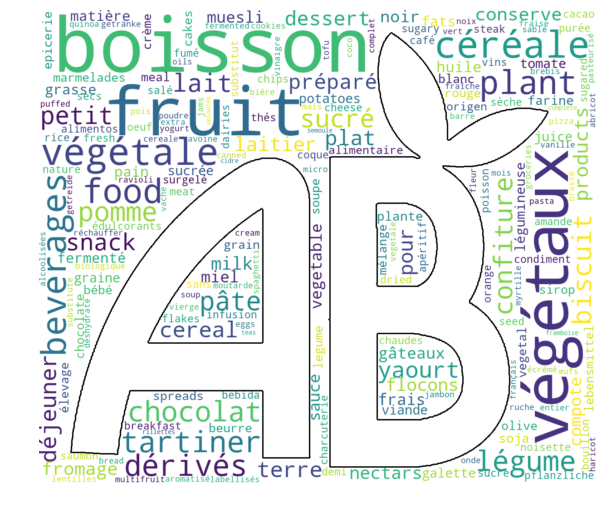

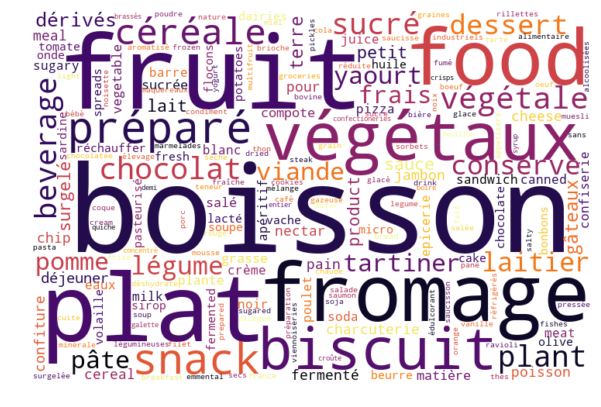

In [15]:
stopwords = {"base", "based", "origine", "produits", "aliment", "aliments"}
maskAB = generate_mask("data/images/logo-ab.jpg")
generateWordCloud(organicDf, stopwords, figsize = (10, 10), colormap = "viridis", mask=maskAB,contour_width=3, contour_color='black')
generateWordCloud(nonOrganicDf, stopwords, figsize = (10, 10), colormap = "inferno")

By looking at the wordclouds, it appears that organic and non organic products cover essetially the same markets. They are both essentially covering *drinks*, *fruits* and *vegetables*. However, they differ on many items. For instance, organic food is more interested in *cereals* and raw food, when non organic one covers more transformed food and already cooked meals.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


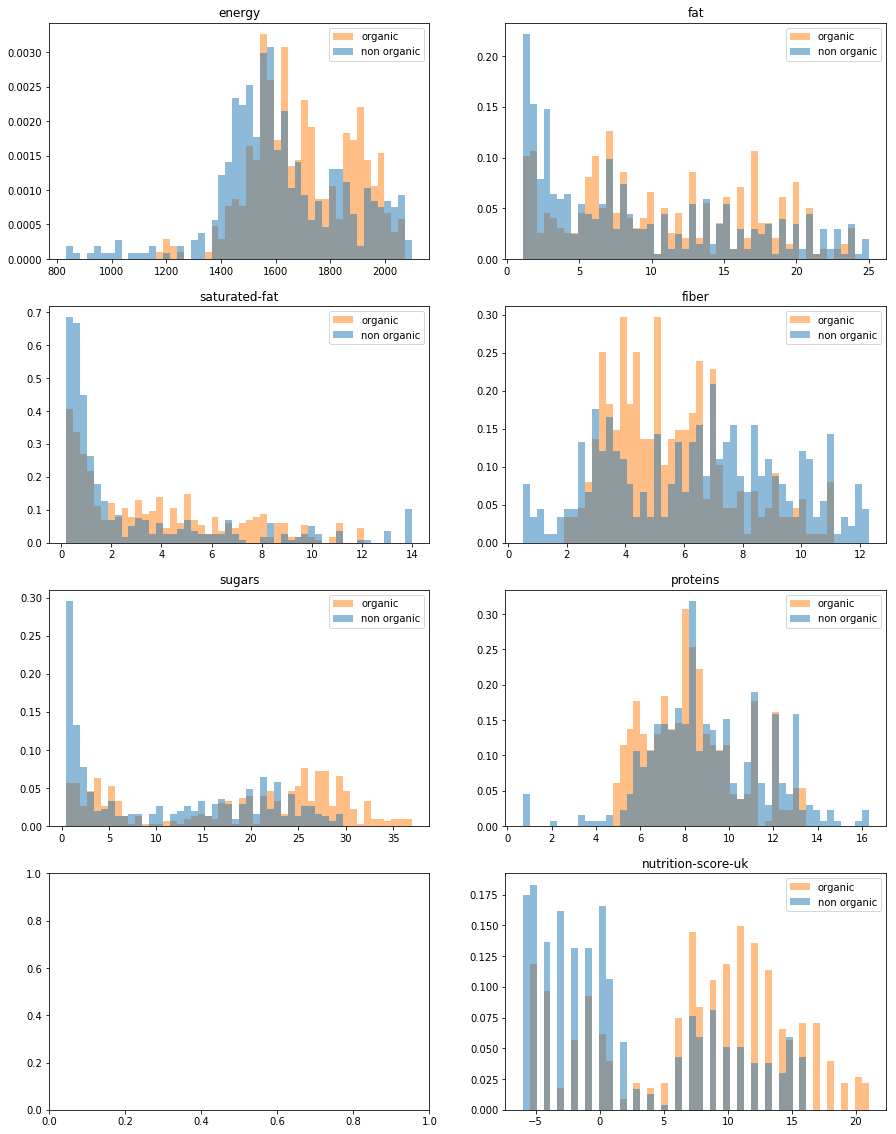

In [23]:
cats = ["céréales"]
catOrganic = gatherCategory(organicDf, cats)
catNOrganic = gatherCategory(nonOrganicDf, cats)
nutriments = ["energy","fat", "saturated-fat","fiber", "sugars","proteins","vitamin-a","nutrition-score-uk"]
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for i, nutriment in enumerate(nutriments):
    orgNut = gatherNutriments(catOrganic, nutriment)
    nOrgNut = gatherNutriments(catNOrganic, nutriment)
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        ax = axes[i // 2, i % 2]
        ax.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        ax.legend(["organic", "non organic"])
        ax.set_title(nutriment)
plt.show()

If we look more specifically at one category, for example *cereals*, we see that most of essential nutriments taken individually do not have a really different distribution between organic and not organic products. However, the nutrition score (the lower the better) is globally better for organic products than non organic ones.

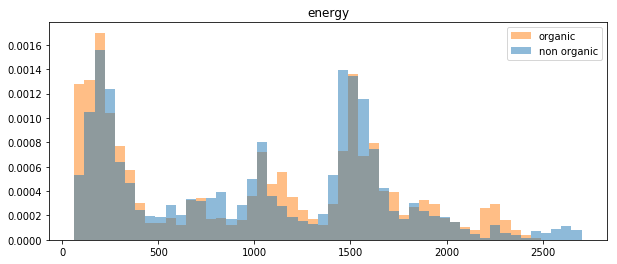

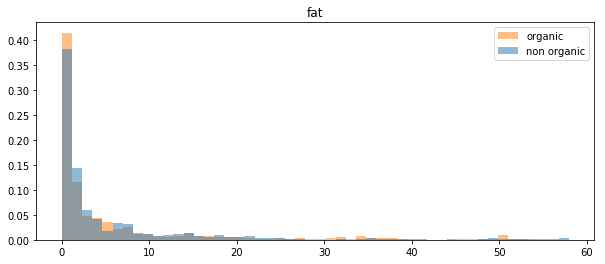

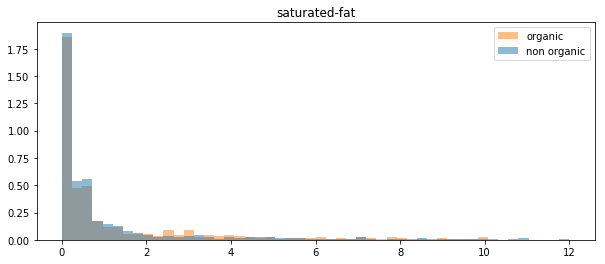

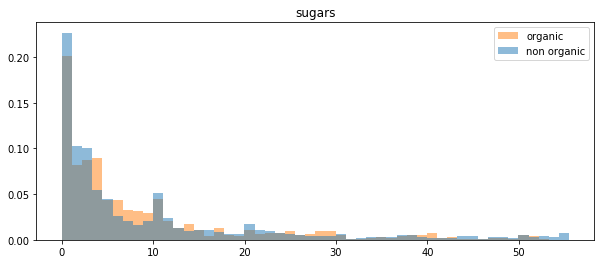

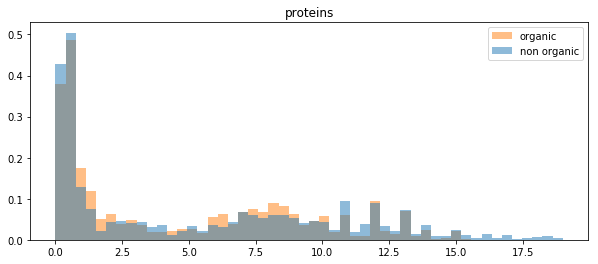

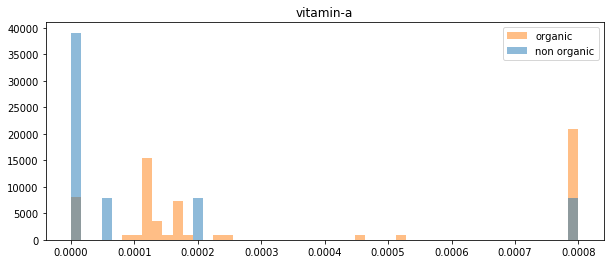

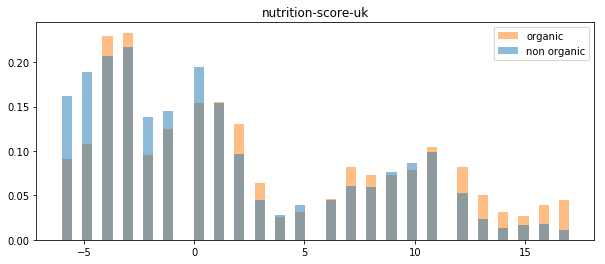

In [20]:
cats = ["boisson"]
catOrganic = gatherCategory(organicDf, cats)
catNOrganic = gatherCategory(nonOrganicDf, cats)

nutriments = ["energy","fat", "saturated-fat","fiber", "sugars","proteins","vitamin-a","nutrition-score-uk"]
for nutriment in nutriments:
    orgNut = gatherNutriments(catOrganic, nutriment)
    nOrgNut = gatherNutriments(catNOrganic, nutriment)
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        plt.figure(figsize=(10, 4))
        plt.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        plt.legend(["organic", "non organic"])
        plt.title(nutriment)
plt.show()

If we look more specifically at another category, for example *drinks*, it seems that even the nutrition score does not differ between the two products.

## Study of INCA 2

### Data cleaning

In [ ]:
# Data
plat = platform.system()
if plat =="Windows":
    encoding = "ansi" # Windows
elif plat =="Darwin":
    encoding = "latin" # Mac
else:
    raise ValueError("unknown os: {}".format(plat))

DATA_PATH = "data/{}.csv"

dfConso = pd.read_csv(DATA_PATH.format("Table_conso"), sep=";", encoding=encoding)
dfIndiv = pd.read_csv(DATA_PATH.format("Table_indiv"), sep=";", encoding=encoding)
dfCapiCA = pd.read_csv(DATA_PATH.format("Table_capi_ca"), sep=";", encoding=encoding)
dfCarnetCA = pd.read_csv(DATA_PATH.format("Table_carnet_ca_1"), sep=";", encoding=encoding)
dfIndivCA = pd.read_csv(DATA_PATH.format("Table_indiv_ca"), sep=";", encoding=encoding)
dfIndnut = pd.read_csv(DATA_PATH.format("Table_indnut"), sep=";", encoding=encoding)
dfMenage = pd.read_csv(DATA_PATH.format("Table_menage_1"), sep=";", encoding=encoding)
dfRepas = pd.read_csv(DATA_PATH.format("Table_repas"), sep=";", encoding=encoding)
dfNomenclature = pd.read_csv(DATA_PATH.format("Nomenclature_3"), sep=";", encoding=encoding)
dfCorrespondance = pd.read_csv(DATA_PATH.format("correspondance_reponses"), sep=";", encoding=encoding)
dfDataNames = pd.read_csv(DATA_PATH.format("Data_names_all"), sep=";", encoding=encoding)

### Data formating

In [ ]:
def findCorrespondance(val, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    """
    Returns the description of the column signification.
    """
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    """
    Returns the description of the columns signification.
    """
    return [findDescription(column) for column in columns]

### Data analysis and visualization

#### BMI study

#### Interest in food

#### Displaying functions

In [ ]:
def plotBar(table, x, y, index=None):
    """
    Plots a stacked normalized bar plot from table. Axis x is x, axis y is y, count is column index.
    """
    if index == None: index = y
    consos = table[[x, y, index]].groupby([x, y]).count().unstack(level=1)[index]
    consos = consos.swapaxes(0,1)
    consos = consos / consos.sum(axis=0)
    consos = consos.swapaxes(0,1)
    consos.index = mapCorrespondances(consos.index, x)
    consos.columns = mapCorrespondances(consos.columns, y)
    consos.plot.bar(stacked=True)
    plt.show()

def plotScatter(table, col1, col2):
    """
    Scatters columns col1 and columns col2 of table
    """
    data = table[[col1, col2]].values
    plt.scatter(data[:,0], data[:,1])
    plt.show()
    
def getBinsFunc(x, nbins):
    """
    Create a function mapping x values into a categorical 
    """
    xmin = np.min(x)
    xmax = np.max(x) * 1.01
    return lambda v: np.int16(nbins * (v - xmin) / (xmax - xmin)) * (xmax - xmin) + xmin
    
def plotScatterCateX(table, x, y, index, nbins):
    """
    Plots a stacked normalized bar plot from table. Axis x is x, axis y is y, count is column index.
    Column index is filtered into nbins bins.
    """
    consos = table[[x, y, index]]
    f = getBinsFunc(consos[y], nbins)
    consos[y] = f(consos[y])
    plotBar(consos, x, y, index)

def plotMeanValues(table, features, className, mincount=50):
    """
    Plot a normalized stacked bar chart of mean values of each features in features for each class according to 
    class name. Consider only classes with at least mincount elements.
    """
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, figsize=figsize)
    plt.show()